In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,TensorDataset

In [2]:
## preprocessing of data

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

holiday_event_data_path = '/Users/sandeep/Desktop/store-sales-time-series-forecasting/holidays_events.csv'
oil_data_path = '/Users/sandeep/Desktop/store-sales-time-series-forecasting/oil.csv'
stores_data_path = '/Users/sandeep/Desktop/store-sales-time-series-forecasting/stores.csv'
test_data_path = '/Users/sandeep/Desktop/store-sales-time-series-forecasting/test.csv'
train_data_path = '/Users/sandeep/Desktop/store-sales-time-series-forecasting/train.csv'
transactions_data_path = '/Users/sandeep/Desktop/store-sales-time-series-forecasting/transactions.csv'

df_oil=pd.read_csv(oil_data_path)
df_oil = df_oil.infer_objects(copy=False)
df_oil.interpolate(method='linear',inplace=True)
df_oil.bfill(inplace=True)

df_train = pd.read_csv(train_data_path, nrows=10000)  # Load only the first 10,000 rows
df_test=pd.read_csv(test_data_path)
df_stores=pd.read_csv(stores_data_path)
df_holiday_event=pd.read_csv(holiday_event_data_path)
df_transactions=pd.read_csv(transactions_data_path)
# print(df_oil.head(50))

/var/folders/d3/sh_q5_g16hz6flw_fh4nr7nh0000gn/T/ipykernel_5511/47776979.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_oil.interpolate(method='linear',inplace=True)


In [3]:
## now merge all data into one file with specific features that are helpfull for prediction

train_data=pd.merge(df_train,df_stores,on='store_nbr',how='left') ## merge df_train and df_test with df_stores with respect to commen store_nbr column
test_data=pd.merge(df_test,df_stores,on='store_nbr',how='left')

train_data=pd.merge(train_data,df_oil,on='date',how='left') ## merge train_data and test_data with df_oil with respect to date column
test_data=pd.merge(test_data,df_oil,on='date',how='left')

train_data=pd.merge(train_data,df_holiday_event,on='date',how='left') ## merge train_data and test_data with df_holiday_event with respect to date column
test_data=pd.merge(test_data,df_holiday_event,on='date',how='left')

train_data=pd.merge(train_data,df_transactions,on=['date','store_nbr'],how='left')
test_data=pd.merge(test_data,df_transactions,on=['date','store_nbr'],how='left')


In [4]:
print(train_data.head())
# print(train_data.columns)

# ## now change the Categorical columns into multiple binary columns(one for each category).
cat_columns=['family','city','state','type_x','type_y','locale','locale_name','description','transferred']
train_data=pd.get_dummies(train_data, columns=cat_columns, drop_first=True)
test_data=pd.get_dummies(test_data, columns=cat_columns, drop_first=True)

train_data.fillna(0,inplace=True)
test_data.fillna(0,inplace=True)
train_data['date']=pd.to_datetime(train_data['date'])
train_data=train_data.astype(int)


   id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type_x  cluster  dcoilwtico   type_y    locale locale_name  \
0  Pichincha      D       13       93.14  Holiday  National     Ecuador   
1  Pichincha      D       13       93.14  Holiday  National     Ecuador   
2  Pichincha      D       13       93.14  Holiday  National     Ecuador   
3  Pichincha      D       13       93.14  Holiday  National     Ecuador   
4  Pichincha      D       13       93.14  Holiday  National     Ecuador   

          description transferred  transactions  
0  Primer dia del ano       False           NaN  
1  Primer dia del ano 

In [5]:
print(train_data.head())
# import matplotlib.pyplot as plt

# # Assuming your data is in a Pandas DataFrame and has a 'date' column
# train_data['date'] = pd.to_datetime(train_data['date'])
# train_data.set_index('date', inplace=True)

# # Plot the sales over time
# plt.figure(figsize=(10,6))
# plt.plot(train_data['sales'])
# plt.title('Sales Over Time')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.show()


   id                 date  store_nbr  sales  onpromotion  cluster  \
0   0  1356998400000000000          1      0            0       13   
1   1  1356998400000000000          1      0            0       13   
2   2  1356998400000000000          1      0            0       13   
3   3  1356998400000000000          1      0            0       13   
4   4  1356998400000000000          1      0            0       13   

   dcoilwtico  transactions  family_BABY CARE  family_BEAUTY  ...  \
0          93             0                 0              0  ...   
1          93             0                 1              0  ...   
2          93             0                 0              1  ...   
3          93             0                 0              0  ...   
4          93             0                 0              0  ...   

   state_Pichincha  state_Santa Elena  state_Santo Domingo de los Tsachilas  \
0                1                  0                                     0   
1     

In [6]:
# import seaborn as sns

# # Correlation heatmap
# plt.figure(figsize=(10,6))
# sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')
# plt.title('Feature Correlation')
# plt.show()


In [8]:

    #     model=nn.Sequential(nn.Linear(self.X.shape[1],64) , # first layer
    #                         nn.ReLU() , 
    #                         nn.Linear(64,32) , # hidden layer
    #                         nn.ReLU() , 
    #                         nn.Linear(32,1) # output layer
    #                        )
    #     return model

    # def train_model(self,epochs): # train the model
    #     for epoch in range(epochs):
    #         for inputs,labels in self.train_loader:
    #             output=self.model(inputs) # forward pass
    #             loss=self.criterion(output.squeeze(),labels) # Compute loss

    #             self.optimizer.zero_grad()  # Zero the gradients
    #             loss.backward() # backward pass
    #             self.optimizer.step() # update the weight
    #     print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

    # def generate_future_features(self, future_periods):
    #     # last_date = pd.to_datetime(dataFrame['date'].iloc[-1])
    #     future_dates = [last_date + timedelta(days=i) for i in range(1, future_periods + 1)]

    #     # Assuming the other features are based on date. Adjust accordingly if features differ.
    #     future_data = pd.DataFrame({'date': future_dates})
    #     future_data['day_of_week'] = future_data['date'].dt.dayofweek
    #     future_data['day_of_month'] = future_data['date'].dt.day
    #     future_data['month'] = future_data['date'].dt.month
    #     # Add any other date-based features that your model expects
        
    #     return future_data.drop(columns=['date'])  # Drop date column if your model does not use it directly
    
#     def predict(self, future_periods=90):
#         future_data = self.generate_future_features(future_periods)
#         future_inputs = torch.tensor(future_data.values, dtype=torch.float32)
        
#         # Predict future sales
#         with torch.no_grad():
#             predictions = self.model(future_inputs).squeeze().numpy()
        
#         return predictions

# if __name__=="__main__":
#     predictor=SalesPrediction(train_data,32)
#     predictor.train_model(10)
    
#     # Predict the next 90 days
#     future_predictions = predictor.predict(future_periods=90)
    
#     # Predict future sales
#     future_predictions = predictor.predict_future(future_data)

#     # Plot predictions
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(len(future_predictions)), future_predictions, label="Future Predictions", linestyle="--")
#     plt.title("Neural Network Future Sales Predictions")
#     plt.xlabel("Days")
#     plt.ylabel("Sales")
#     plt.legend()
#     plt.show()


DEBUG:cmdstanpy:input tempfile: /var/folders/d3/sh_q5_g16hz6flw_fh4nr7nh0000gn/T/tmpza969opf/oejm4h19.json
DEBUG:cmdstanpy:input tempfile: /var/folders/d3/sh_q5_g16hz6flw_fh4nr7nh0000gn/T/tmpza969opf/lq5q9wuq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97207', 'data', 'file=/var/folders/d3/sh_q5_g16hz6flw_fh4nr7nh0000gn/T/tmpza969opf/oejm4h19.json', 'init=/var/folders/d3/sh_q5_g16hz6flw_fh4nr7nh0000gn/T/tmpza969opf/lq5q9wuq.json', 'output', 'file=/var/folders/d3/sh_q5_g16hz6flw_fh4nr7nh0000gn/T/tmpza969opf/prophet_modelm8r3sp8w/prophet_model-20241107010916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

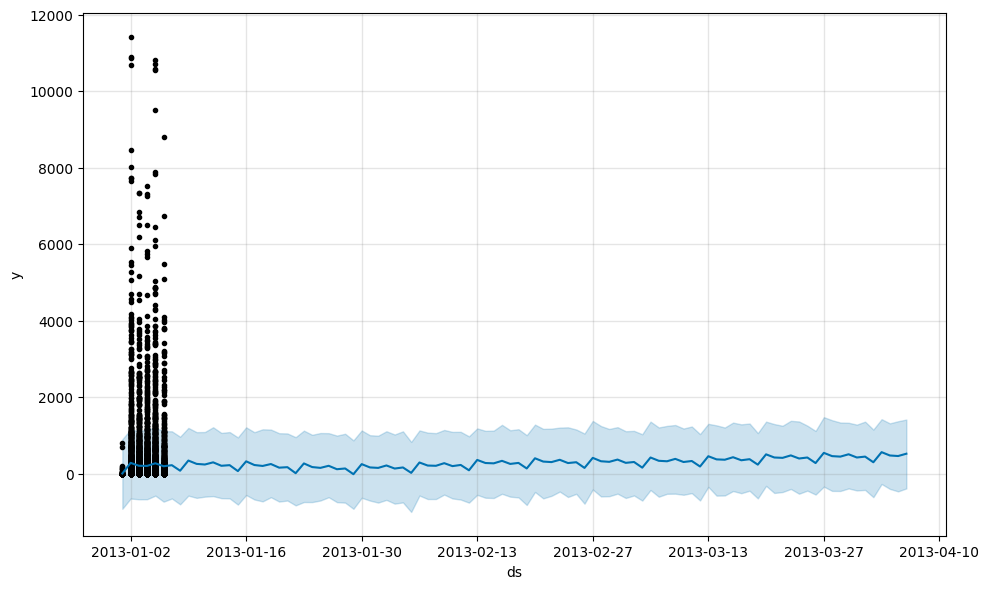

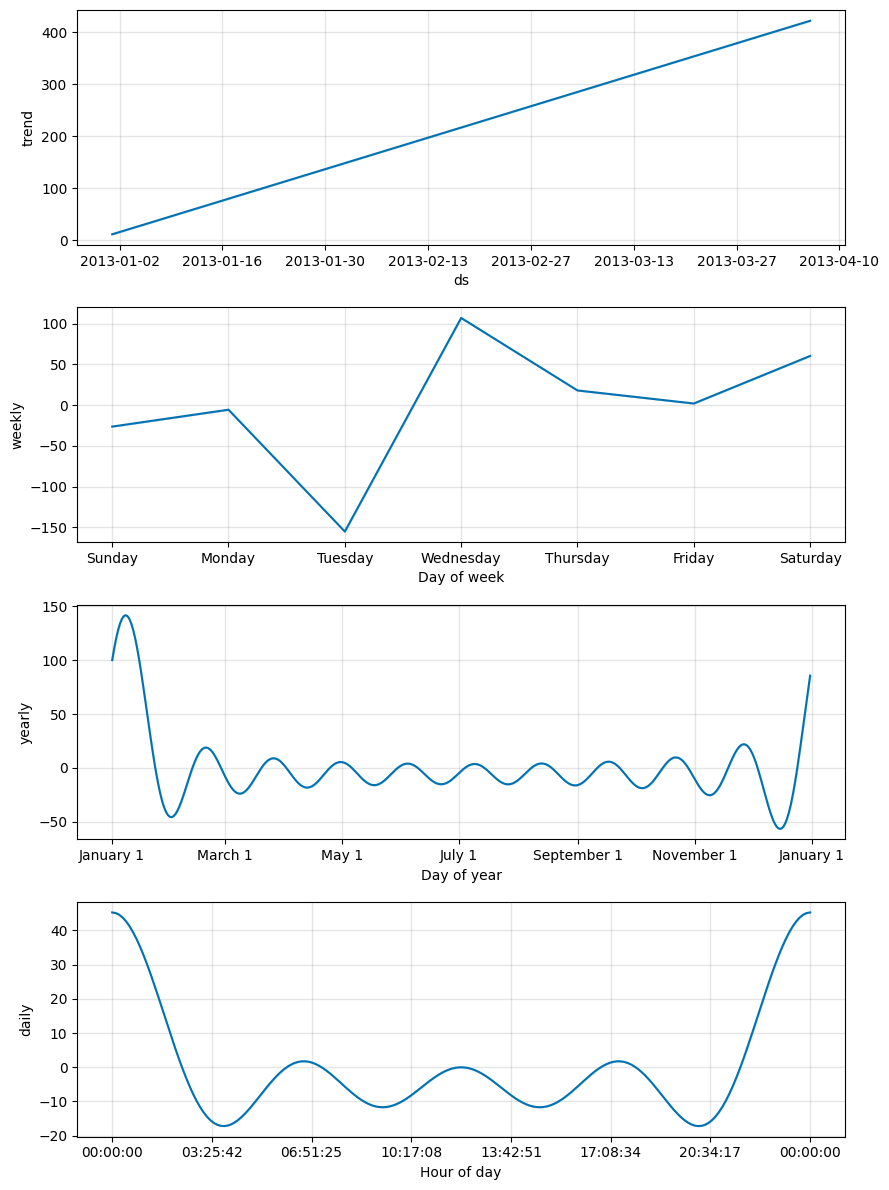

In [9]:
from prophet import Prophet

class ProphetPredictSales:
    def __init__(self,data):
        # Prepare the data in Prophet's required format: ds (date), y (target variable)
        self.data=data.rename(columns={'date':'ds','sales':'y'})
        self.data['ds']=pd.to_datetime(self.data['ds'])
        # Converting only specific columns if needed
        self.data['y'] = self.data['y'].astype(float)  # Ensure sales is a float

        self.model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

    def fit(self):
        # Fit the model to the training data
        self.model.fit(self.data)

    def predict(self,future_periods):
        # Create a dataframe to hold future dates for forecasting
        future=self.model.make_future_dataframe(periods=future_periods)
        forecast=self.model.predict(future) # predicts the future instanses
        return forecast
        
    def plot(self, forecast):
        # Plot the forecast
        self.model.plot(forecast)
        self.model.plot_components(forecast)

import logging

# Set up logging to see the output
logging.basicConfig(level=logging.INFO)

# Example usage
if __name__ == "__main__":
    # Load and preprocess your data here
    # train_data = pd.read_csv('path_to_your_train_data.csv')

    predictor = ProphetPredictSales(train_data)
    predictor.fit()
    
    # Predict sales for the next 90 days
    forecast = predictor.predict(future_periods=90)
    
    # Optionally plot the forecast
    predictor.plot(forecast)
